# IMD3004 - Aprendizado Profundo

### Professor: Dr. Silvan Ferreira da Silva Junior

### Aluno: João Antonio Costa Paiva Chagas

# Laboratório 15: Custom Dataset

# Atividade: CNNs para Classificação

Neste notebook, iremos preparar nosso próprio dataset e treinar um modelo de classificação de imagens.

## Importações

In [1]:
!pip install icrawler

In [2]:
import os
import re
import sys
import time
import glob
import torch
import shutil
import random
import logging
import numpy as np
import seaborn as sns
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from icrawler.builtin import GoogleImageCrawler, BingImageCrawler
from sklearn.metrics import classification_report, confusion_matrix

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


## Preparando os dados

Os dados desta atividade serão baixados da internet. Utilizaremos para isso buscadores comuns. Em seguida, dividiremos em treinamento e validação.

### Tornando os logs mais legíveis

In [3]:
class CleanLogHandler(logging.Handler):
    def __init__(self):
        super().__init__()
        # Grupo 1 (\d+):   Código de status (ex: 403)
        # Grupo 2 ([^/]+): Domínio do site  (ex: upload.wikimedia.org)
        self.regex = re.compile(r"Response status code (\d+), file https?://([^/]+)")

    def emit(self, record):
        msg = self.format(record)

        match = self.regex.search(msg)

        if match:
            status_code = match.group(1)
            domain = match.group(2)

            if status_code == '400':
                print(f"    -> [Downloader] Falha: O site '{domain}' não entendeu a requisição (400 Bad Request).")
            elif status_code == '401':
                print(f"    -> [Downloader] Falha: O site '{domain}' requer autenticação (401 Unauthorized).")
            elif status_code == '403':
                print(f"    -> [Downloader] Falha ao baixar porque o site '{domain}' proibiu o acesso (403 Proibido).")
            elif status_code == '404':
                print(f"    -> [Downloader] Falha ao baixar porque a imagem no site '{domain}' não foi encontrada (404 Link Quebrado).")
            elif status_code == '406':
                print(f"    -> [Downloader] Falha: O site '{domain}' não tem um formato de resposta aceitável (406 Not Acceptable).")
            elif status_code == '429':
                print(f"    -> [Downloader] Falha ao baixar porque o site '{domain}' nos bloqueou por muitas requisições (429 Rate Limit).")
            elif status_code == '504':
                print(f"    -> [Downloader] Falha: O servidor do site '{domain}' demorou demais (504 Gateway Timeout).")
            else:
                # Mensagem genérica para outros códigos (400, 401, 500, etc.)
                print(f"    -> [Downloader] Falha ao baixar porque o site '{domain}' deu um erro (Código {status_code}).")

        elif "Read timed out" in msg:
            print("    -> [Downloader] Falha ao baixar porque o servidor demorou demais para responder (Tempo Esgotado).")

        elif "CERTIFICATE_VERIFY_FAILED" in msg:
            print("    -> [Downloader] Falha ao baixar devido a um erro no certificado de segurança (SSL) do site.")

In [4]:
downloader_logger = logging.getLogger('downloader')
downloader_logger.setLevel(logging.ERROR)
downloader_logger.handlers = []
downloader_logger.addHandler(CleanLogHandler())
downloader_logger.propagate = False

### Adquirindo as Imagens

Utilizaremos o iCrawler para baixar imagens em buscadores através de termos especificados. Defina sua lista de classes.

In [5]:
def download_and_verify_images(keyword, folder, n_total=100):
    os.makedirs(folder, exist_ok=True)

    imagens_validas = 0
    file_index_offset = 0

    print(f"Baixando imagens de '{keyword}'. Alvo: {n_total} imagens válidas.")
    while imagens_validas < n_total:
        imagens_faltando = n_total - imagens_validas

        compensacao = imagens_faltando + 10

        print(f"\nAlvo: {n_total} | Válidas: {imagens_validas} | Buscando mais {compensacao}...")

        imagens_antes_do_crawl = set(os.listdir(folder))

        try:
            crawler = BingImageCrawler(storage={'root_dir': folder})
            crawler.crawl(keyword=keyword,
                          max_num=compensacao,
                          file_idx_offset=file_index_offset)
        except Exception as e:
            print(f"  -> [Crawler] Erro Inesperado: {e}. Tentando novamente...")
            time.sleep(5)
            continue

        imagens_depois_do_crawl = set(os.listdir(folder))

        novas_imagens = imagens_depois_do_crawl - imagens_antes_do_crawl

        if not novas_imagens:
            print("  -> [Crawler] Não encontrou novas imagens. Parando.")
            break


        print(f"  -> {len(novas_imagens)} baixadas. Verificando...")

        novas_imagens_validas_encontradas = 0
        for filename in novas_imagens:
            file_path = os.path.join(folder, filename)
            if not os.path.isfile(file_path):
                continue

            try:
                with Image.open(file_path) as img:
                    img.load()
                # Imagem é válida!
                novas_imagens_validas_encontradas += 1
            except (IOError, OSError, Image.UnidentifiedImageError):
                # Imagem corrompida.
                print(f"    -> Removendo imagem corrompida: {filename}")
                os.remove(file_path)

        print(f"  -> Verificação concluída: {novas_imagens_validas_encontradas} novas imagens válidas.")
        imagens_validas += novas_imagens_validas_encontradas

        # Atualiza o offset para o próximo loop, para evitar sobrescrever arquivos
        file_index_offset = len(os.listdir(folder))

    print(f"\n--- Download concluído para '{keyword}' ---")
    print(f"Total de imagens válidas na pasta: {imagens_validas}\n")

Coloquei uma compensação de 10 imagens extras, caso imagens corrompidas sejam baixadas.

In [6]:
search_terms = {
    "Obama": "Barack Obama",
    "Trump": "Donald Trump",
    "Biden": "Joe Biden",
    "Bush": "George W. Bush",
    "Clinton": "Bill Clinton",
}

for label, term in search_terms.items():
    download_and_verify_images(term, f"data/presidents/{label}", n_total=100)

Baixando imagens de 'Barack Obama'. Alvo: 100 imagens válidas.

Alvo: 100 | Válidas: 0 | Buscando mais 110...
    -> [Downloader] Falha ao baixar porque o servidor demorou demais para responder (Tempo Esgotado).
    -> [Downloader] Falha ao baixar porque o servidor demorou demais para responder (Tempo Esgotado).
    -> [Downloader] Falha ao baixar porque o servidor demorou demais para responder (Tempo Esgotado).
  -> 28 baixadas. Verificando...
  -> Verificação concluída: 28 novas imagens válidas.

Alvo: 100 | Válidas: 28 | Buscando mais 82...
    -> [Downloader] Falha ao baixar porque o servidor demorou demais para responder (Tempo Esgotado).
    -> [Downloader] Falha ao baixar porque o servidor demorou demais para responder (Tempo Esgotado).
    -> [Downloader] Falha ao baixar porque o servidor demorou demais para responder (Tempo Esgotado).
  -> 29 baixadas. Verificando...
  -> Verificação concluída: 29 novas imagens válidas.

Alvo: 100 | Válidas: 57 | Buscando mais 53...
    -> [Do

### Treinamento e Validação

Dividiremos as imagens baixadas nas pastas `train` e `val`. Defina uma porcentagem.

In [7]:
def split_train_val(root_dir, train_ratio=0.8, seed=42):
    random.seed(seed)

    train_dir = root_dir + "_split/train"
    val_dir = root_dir + "_split/val"

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    for class_name in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = [os.path.join(class_path, f) for f in os.listdir(class_path)]
        images = [f for f in images if os.path.isfile(f)]
        random.shuffle(images)

        n_train = int(len(images) * train_ratio)

        train_class_dir = os.path.join(train_dir, class_name)
        val_class_dir = os.path.join(val_dir, class_name)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(val_class_dir, exist_ok=True)

        for img in images[:n_train]:
            shutil.copy(img, os.path.join(train_class_dir, os.path.basename(img)))
        for img in images[n_train:]:
            shutil.copy(img, os.path.join(val_class_dir, os.path.basename(img)))

        print(f"{class_name}: {n_train} train, {len(images)-n_train} val")

## Funções auxiliares

In [8]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')

        for phase, loader in [('train', train_loader), ('val', val_loader)]:
            if phase == 'train':
                model.train()  # modelo em treino
            else:
                model.eval()   # modelo em avaliação

            running_loss, running_corrects = 0.0, 0
            size = len(loader.dataset)

            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):

                    outputs = model(inputs)

                    if phase == 'train':
                        # Em modo .train() retorna um objeto com 3 saídas
                        # (main_output, aux1_output, aux2_output)
                        main_output, aux1_output, aux2_output = outputs

                        loss1 = criterion(main_output, labels)
                        loss2 = criterion(aux1_output, labels)
                        loss3 = criterion(aux2_output, labels)

                        loss = loss1 + 0.3 * loss2 + 0.3 * loss3

                        _, preds = torch.max(main_output, 1)
                    else:
                        # Em modo .eval() retorna uma única saída
                        loss = criterion(outputs, labels)
                        _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)

            epoch_loss = running_loss / size
            epoch_acc = running_corrects.double() / size
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model, history

In [9]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history['train_acc'], label='Train Accuracy')
    ax1.plot(history['val_acc'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(history['train_loss'], label='Train Loss')
    ax2.plot(history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.show()

In [10]:
def predict_image(image_path, model, transform, class_names):
    """
    Carrega uma imagem, aplica as transformações e retorna a predição do modelo.
    """
    # Carregando a imagem
    try:
        image = Image.open(image_path).convert('RGB')
    except Exception as e:
        print(f"Erro ao carregar a imagem {image_path}: {e}")
        return None

    # Aplicando as transformações de validação
    image_tensor = transform(image).unsqueeze(0)
    image_tensor = image_tensor.to(device)

    # Modelo em avaliação
    model.eval()

    # Prediz
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted_idx = torch.max(outputs, 1)

    # Retorna o nome da classe
    return class_names[predicted_idx.item()]

## Dataset

Implemente um Dataset PyTorch que carregue as imagens baixadas com suas respectivas classes. Aplique data augmentation e carregue em batches.

In [11]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = "data/presidents"
split_train_val(data_dir)

train_dir = data_dir + "_split/train"
val_dir = data_dir + "_split/val"

image_datasets = {
    'train': ImageFolder(train_dir, data_transforms['train']),
    'val': ImageFolder(val_dir, data_transforms['val'])
}

train_dataloader = DataLoader(image_datasets['train'], batch_size=4, shuffle=True, num_workers=4)
val_dataloader = DataLoader(image_datasets['val'], batch_size=4, shuffle=False, num_workers=4)

class_names = image_datasets['train'].classes
train_size = len(image_datasets['train'])
val_size = len(image_datasets['val'])

print(f"Classes: {class_names}")
print(f"Train size: {train_size}")
print(f"Val size: {val_size}")

Biden: 81 train, 21 val
Trump: 88 train, 22 val
Bush: 83 train, 21 val
Clinton: 88 train, 22 val
Obama: 88 train, 22 val
Classes: ['Biden', 'Bush', 'Clinton', 'Obama', 'Trump']
Train size: 428
Val size: 108


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Definição do Modelo

Defina aqui o modelo que será utilizado, sendo implementação própria ou um modelo pré-treinado.

In [12]:
googlenet_pretrained = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT, aux_logits=True)

for param in googlenet_pretrained.parameters():
    param.requires_grad = False

numero_de_features = googlenet_pretrained.fc.in_features
googlenet_pretrained.fc = nn.Linear(numero_de_features, len(class_names))

num_features_aux1 = googlenet_pretrained.aux1.fc2.in_features
googlenet_pretrained.aux1.fc2 = nn.Linear(num_features_aux1, len(class_names))

num_features_aux2 = googlenet_pretrained.aux2.fc2.in_features
googlenet_pretrained.aux2.fc2 = nn.Linear(num_features_aux2, len(class_names))

for param in googlenet_pretrained.inception5b.parameters():
    param.requires_grad = True

googlenet_pretrained = googlenet_pretrained.to(device)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


100%|██████████| 49.7M/49.7M [00:00<00:00, 188MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn(


## Treinamento

Defina a função de custo e o otimizador do modelo. Em seguida, implemente o código de treinamento e treine-o. Ao final, exiba as curvas de treinamento e validação para a loss e a acurácia.


Epoch 1/25
Train Loss: 2.7216 Acc: 0.2734
Val Loss: 1.6597 Acc: 0.2037

Epoch 2/25
Train Loss: 2.5528 Acc: 0.3318
Val Loss: 1.2359 Acc: 0.5648

Epoch 3/25
Train Loss: 2.3976 Acc: 0.3995
Val Loss: 1.0682 Acc: 0.6852

Epoch 4/25
Train Loss: 2.2427 Acc: 0.4836
Val Loss: 1.0850 Acc: 0.5741

Epoch 5/25
Train Loss: 2.1804 Acc: 0.5140
Val Loss: 0.9471 Acc: 0.6574

Epoch 6/25
Train Loss: 2.1877 Acc: 0.5280
Val Loss: 0.9436 Acc: 0.6852

Epoch 7/25
Train Loss: 2.1978 Acc: 0.5467
Val Loss: 0.8255 Acc: 0.7222

Epoch 8/25
Train Loss: 2.1619 Acc: 0.5350
Val Loss: 0.7025 Acc: 0.7870

Epoch 9/25
Train Loss: 2.0675 Acc: 0.5818
Val Loss: 0.7008 Acc: 0.8056

Epoch 10/25
Train Loss: 1.9980 Acc: 0.6075
Val Loss: 0.7316 Acc: 0.7130

Epoch 11/25
Train Loss: 2.0693 Acc: 0.5514
Val Loss: 0.5934 Acc: 0.8241

Epoch 12/25
Train Loss: 1.9564 Acc: 0.6051
Val Loss: 0.5450 Acc: 0.8704

Epoch 13/25
Train Loss: 1.8848 Acc: 0.6659
Val Loss: 0.5188 Acc: 0.8333

Epoch 14/25
Train Loss: 1.9513 Acc: 0.6028
Val Loss: 0.5493

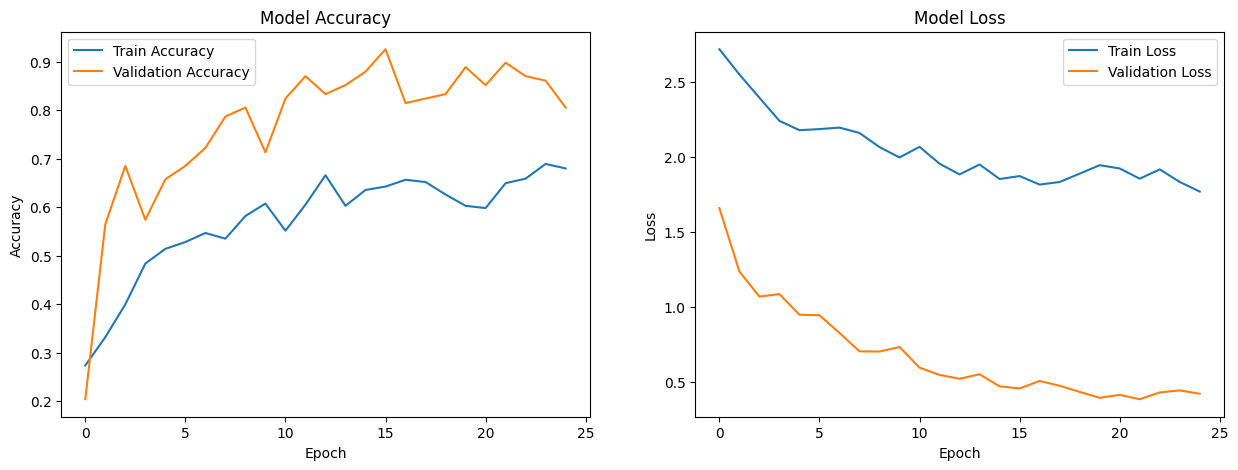

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer_googlenet = optim.Adam([
    {'params': googlenet_pretrained.fc.parameters(), 'lr': 1e-3},
    {'params': googlenet_pretrained.aux1.fc2.parameters(), 'lr': 1e-3},
    {'params': googlenet_pretrained.aux2.fc2.parameters(), 'lr': 1e-3},
    {'params': googlenet_pretrained.inception5b.parameters(), 'lr': 1e-5}
], lr=1e-3)

modelo, history_googlenet = train_model(
    googlenet_pretrained, criterion, optimizer_googlenet, train_dataloader, val_dataloader, num_epochs=25
)

print(f"Plots GoogLeNet")
plot_history(history_googlenet)

## Inferência

Calcule algumas métricas como acurácia, matriz de confusão, etc. Em seguida, teste o modelo em novas imagens das classes correspondentes mas de outras fontes (outro buscador, fotos próprias, etc).

Iniciando avaliação no dataset de validação...

--- Relatório da Classificação ---
              precision    recall  f1-score   support

       Biden       0.67      0.95      0.78        21
        Bush       0.86      0.90      0.88        21
     Clinton       0.70      0.32      0.44        22
       Obama       0.88      1.00      0.94        22
       Trump       0.90      0.86      0.88        22

    accuracy                           0.81       108
   macro avg       0.80      0.81      0.79       108
weighted avg       0.80      0.81      0.78       108


--- Matriz de Confusão ---


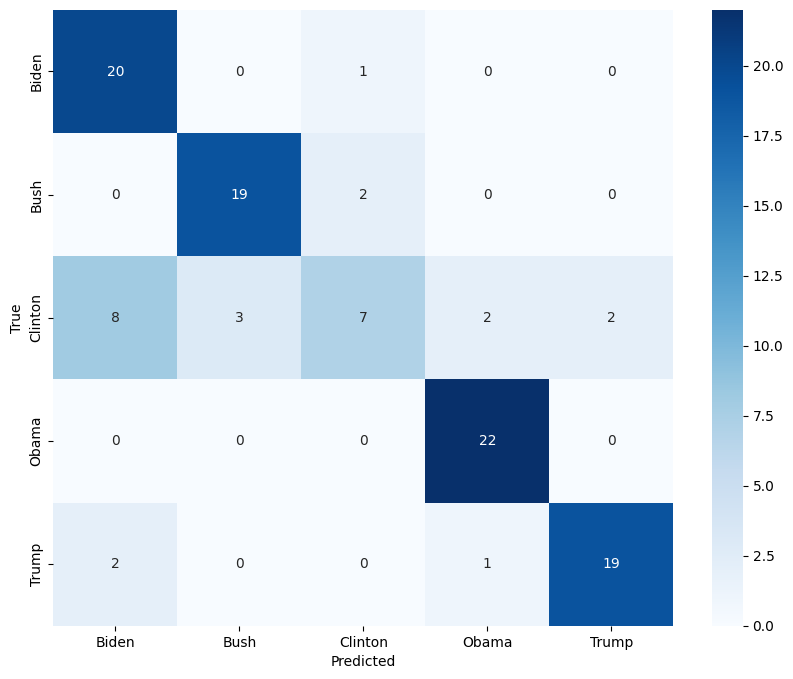

In [14]:
modelo.eval()

y_pred = []
y_true = []

print("Iniciando avaliação no dataset de validação...")
with torch.no_grad():
    for inputs, labels in val_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = modelo(inputs)
        _, preds = torch.max(outputs, 1)

        y_pred.extend(preds.view(-1).cpu().numpy())
        y_true.extend(labels.view(-1).cpu().numpy())

print("\n--- Relatório da Classificação ---")
print(classification_report(y_true, y_pred, target_names=class_names))


print("\n--- Matriz de Confusão ---")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Antes de executar essa célula, crie uma nova pasta chamada "test_imagens_novas" dentro da pasta data e insira as imagens "inéditas" ao modelo.

--- Testando em Novas Imagens (15 imagens que baixei manualmente) ---


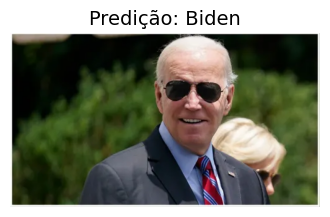

Arquivo: biden-manual01.webp  ->  Predição: Biden



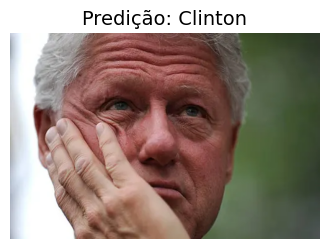

Arquivo: clinton-manual03.webp  ->  Predição: Clinton



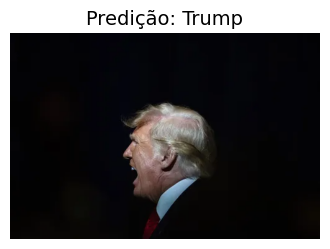

Arquivo: trump-manual03.webp  ->  Predição: Trump



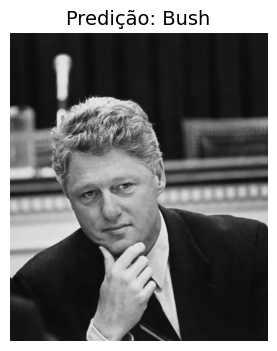

Arquivo: clinton-manual01.webp  ->  Predição: Bush



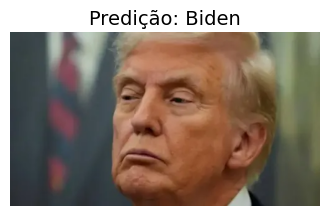

Arquivo: trump-manual02.webp  ->  Predição: Biden



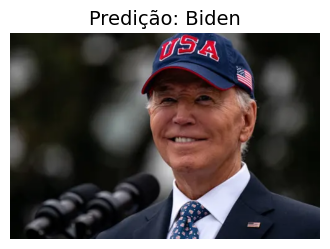

Arquivo: biden-manual03.webp  ->  Predição: Biden



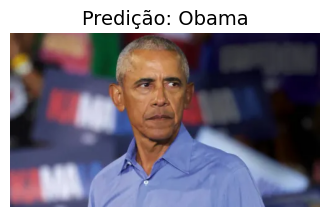

Arquivo: obama-manual01.webp  ->  Predição: Obama



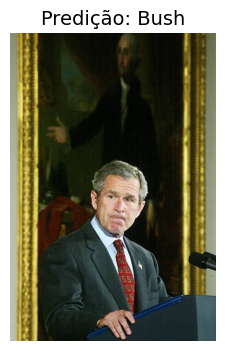

Arquivo: bush-manual03.webp  ->  Predição: Bush



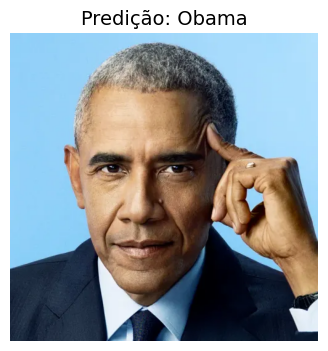

Arquivo: obama-manual03.webp  ->  Predição: Obama



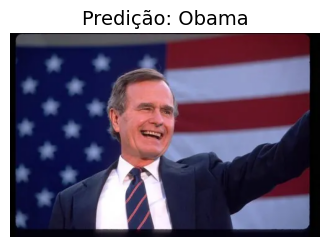

Arquivo: bush-manual01.webp  ->  Predição: Obama



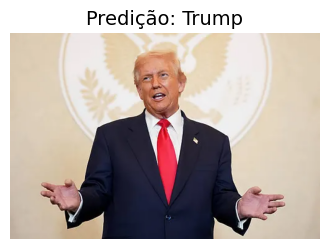

Arquivo: trump-manual01.webp  ->  Predição: Trump



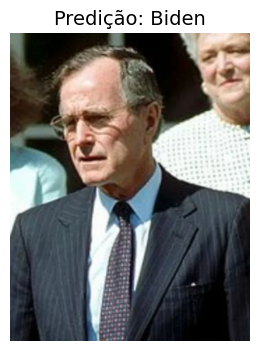

Arquivo: bush-manual02.webp  ->  Predição: Biden



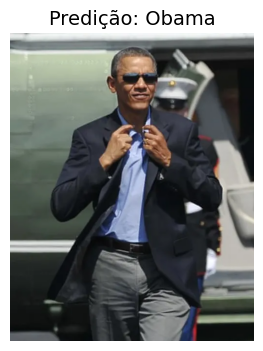

Arquivo: obama-manual02.webp  ->  Predição: Obama



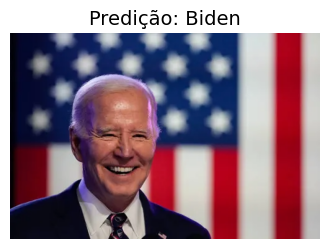

Arquivo: biden-manual02.webp  ->  Predição: Biden



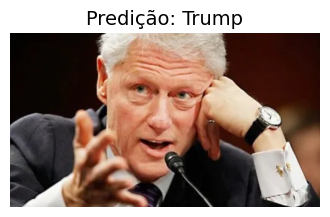

Arquivo: clinton-manual02.webp  ->  Predição: Trump



In [17]:
print("--- Testando em Novas Imagens (15 imagens que baixei manualmente) ---")

test_folder = "data/test_imagens_novas/"

image_paths = glob.glob(os.path.join(test_folder, '*.jpg'))
image_paths.extend(glob.glob(os.path.join(test_folder, '*.png')))
image_paths.extend(glob.glob(os.path.join(test_folder, '*.jpeg')))
image_paths.extend(glob.glob(os.path.join(test_folder, '*.webp')))

if not image_paths:
    print(f"\nAVISO: Nenhuma imagem encontrada em '{test_folder}'.")
else:
    # Usa a função auxiliar de predição em cada imagem
    for img_path in image_paths:
        prediction = predict_image(img_path, modelo, data_transforms['val'], class_names)

        if prediction:
            # Exibindo a imagem e a predição associada
            img = Image.open(img_path)
            plt.figure(figsize=(4, 4))
            plt.imshow(img)
            plt.title(f"Predição: {prediction}", fontsize=14)
            plt.axis('off')
            plt.show()
            print(f"Arquivo: {os.path.basename(img_path)}  ->  Predição: {prediction}\n")